# Fraud Transaction Detection

In [4]:
import datetime
import time
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns;

from sklearn import neighbors,metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier

from operator import itemgetter
from itertools import groupby
import numpy as np
import pandas as pd
from pandas import DataFrame
from imblearn.over_sampling import SMOTE
from collections import Counter


In [3]:
#!pip install imblearn

In [7]:
def xrange(x):
    return iter(range(x))

def string_to_timestamp(date_string):#convert time string to float value
    time_stamp = time.strptime(date_string, '%Y-%m-%d %H:%M:%S')
    return time.mktime(time_stamp)

def aggregate(before_aggregate, aggregate_feature):
    if aggregate_feature == 'day':
        after_aggregate = []
        pos_date = -1
        before_aggregate.sort(key = itemgetter(9))#sort by timestamp
        # print(itemgetter(9))
        #print(itemgetter(-2))
        temp = groupby(before_aggregate, itemgetter(-1))
        group_unit = []
        mean = []
        for i, item in temp:# i is group id
            for jtem in item:# unit in each group
                group_unit.append(jtem)

            # for feature_i in xrange(6):
            #    print(feature_i)
            #    mean.append(zip(group_unit)[feature_i])
            after_aggregate.append(group_unit)
            #after_aggregate.append(mean)
            group_unit = []
        #print after_aggregate[0]
        #print before_aggregate[0]
    if aggregate_feature == 'client':
        after_aggregate = []
        pos_client = -3
        before_aggregate.sort(key = itemgetter(pos_client))#sort with cardID firstly，if sort with 2 feature, itemgetter(num1,num2)
        temp = groupby(before_aggregate, itemgetter(pos_client))#group
        group_unit = []
        for i, item in temp:# i is group id
            for jtem in item:# unit in each group
                group_unit.append(jtem)
            after_aggregate.append(group_unit)
            group_unit = []
    return after_aggregate

def aggregate_mean(before_aggregate):
    #print before_aggregate[0]
    if True:
        after_aggregate = []
        pos_date = -1
        before_aggregate.sort(key = itemgetter(-1))#sort by timestamp
        temp = groupby(before_aggregate, itemgetter(-1))
        group_unit = []
        mean = []
        for i, item in temp:# i is group id
            for jtem in item:# unit in each group
                group_unit.append(list(jtem))
            #print group_unit
            if len(zip(group_unit)) < 2:
                after_aggregate.append(group_unit)
                group_unit = []
            if len(zip(group_unit)) >= 2:
                #print zip(group_unit)
                for feature_i in xrange(14):
                    #print zip(group_unit)[feature_i]
                    mean.append(sum(zip(*group_unit)[feature_i])/len(zip(group_unit)))
                after_aggregate.append(mean)
                group_unit = []
                mean = []
        #print after_aggregate[0]
        #print before_aggregate[0]
    return after_aggregate


In [8]:
src = 'data/data_for_student_case.csv'
ah = open(src, 'r')

data = []
color = []
(issuercountry_set, txvariantcode_set, currencycode_set, shoppercountry_set, interaction_set,
verification_set, accountcode_set, mail_id_set, ip_id_set, card_id_set) = [set() for _ in xrange(10)]
(issuercountry_dict, txvariantcode_dict, currencycode_dict, shoppercountry_dict, interaction_dict,
verification_dict, accountcode_dict, mail_id_dict, ip_id_dict, card_id_dict) = [{} for _ in xrange(10)]

In [9]:
ah.readline()#skip first line
for line_ah in ah:
    if line_ah.strip().split(',')[9]=='Refused':# remove the row with 'refused' label, since it's uncertain about fraud
        continue
    if 'na' in str(line_ah.strip().split(',')[14]).lower() or 'na' in str(line_ah.strip().split(',')[4].lower()):
        continue
    bookingdate = string_to_timestamp(line_ah.strip().split(',')[1])# date reported flaud
    issuercountry = line_ah.strip().split(',')[2]#country code
    issuercountry_set.add(issuercountry)
    txvariantcode = line_ah.strip().split(',')[3]#type of card: visa/master
    txvariantcode_set.add(txvariantcode)
    issuer_id = float(line_ah.strip().split(',')[4])#bin card issuer identifier
    amount = float(line_ah.strip().split(',')[5])#transaction amount in minor units
    currencycode = line_ah.strip().split(',')[6]
    currencycode_set.add(currencycode)
    shoppercountry = line_ah.strip().split(',')[7]#country code
    shoppercountry_set.add(shoppercountry)
    interaction = line_ah.strip().split(',')[8]#online transaction or subscription
    interaction_set.add(interaction)
    if line_ah.strip().split(',')[9] == 'Chargeback':
        label = 1#label fraud
    else:
        label = 0#label save
    verification = line_ah.strip().split(',')[10]#shopper provide CVC code or not
    verification_set.add(verification)
    cvcresponse = line_ah.strip().split(',')[11]#0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
    # if cvcresponse > 2:
    #     cvcresponse = 3
    year_info = datetime.strptime(line_ah.strip().split(',')[12],'%Y-%m-%d %H:%M:%S').year
    month_info = datetime.strptime(line_ah.strip().split(',')[12],'%Y-%m-%d %H:%M:%S').month
    day_info = datetime.strptime(line_ah.strip().split(',')[12],'%Y-%m-%d %H:%M:%S').day
    creationdate = str(year_info)+'-'+str(month_info)+'-'+str(day_info)#Date of transaction
    creationdate_stamp = string_to_timestamp(line_ah.strip().split(',')[12])#Date of transaction-time stamp
    accountcode = line_ah.strip().split(',')[13]#merchant’s webshop
    accountcode_set.add(accountcode)
    mail_id = int(float(line_ah.strip().split(',')[14].replace('email','')))#mail
    mail_id_set.add(mail_id)
    ip_id = int(float(line_ah.strip().split(',')[15].replace('ip','')))#ip
    ip_id_set.add(ip_id)
    card_id = int(float(line_ah.strip().split(',')[16].replace('card','')))#card
    card_id_set.add(card_id)
    data.append([issuercountry, txvariantcode, issuer_id, amount, currencycode,
                shoppercountry, interaction, verification, cvcresponse, creationdate_stamp,
                 accountcode, mail_id, ip_id, card_id, label, creationdate])# add the interested features here

    #y.append(label)# add the labels

In [10]:
data = sorted(data, key = lambda k: k[-1])

data_all = DataFrame(data)
data_all.columns = ['issuercountry', 'txvariantcode', 'issuer_id', 'amount', 'currencycode',
                'shoppercountry', 'interaction', 'verification', 'cvcresponse', 'creationdate_stamp',
                 'accountcode','mail_id', 'ip_id', 'card_id', 'label', 'creationdate']


### transfer currency

In [11]:
def currency_trans(currencycode, amount):
    if currencycode == 'MXN':
        amount = 0.043*amount
    if currencycode =='AUD':
        amount = 0.63*amount
    if currencycode =='NZD':
        amount = 0.59*amount
    if currencycode == 'GBP':
        amount = 1.13*amount
    if currencycode == 'SEK':
        amount = 0.095*amount
    return amount

### datetime processing

In [16]:
data_all = data_all.sort_values(by = ['creationdate'],ascending=True)

In [87]:
data_all = data_all.sort_values(by = ['creationdate'],ascending=True)
data_all['creationdate'] = pd.to_datetime(data_all['creationdate'])
# data_all.set_index("creationdate", inplace=True)
# data_all.resample('W').count()
data_all.index = range(len(data_all))

def freq_count(data_all,label):

    fraud_data = data_all.loc[data_all['label']==label]
    fraud_data.index = range(len(fraud_data))
    fraud_id = fraud_data['card_id'].unique()
    #print(len(fraud_data))
    if len(fraud_data)<380:
        idx = fraud_id
    else:
        idx = random.sample(list(fraud_id), 1000)
    tran_fraud_card = data_all.loc[data_all['card_id'].isin(idx)]
    tran_fraud_card.index = range(len(tran_fraud_card))
    first_date = tran_fraud_card['creationdate'][0]
    #first_date.weekday_name
    # last_date = pd.to_datetime(data_all['creationdate'][-1:].values[0])
    # week_range = time_range/7 + 1
    # weeks = pd.date_range(str(first_date), periods=week_range, freq='W-WED')

    '''put dates into week session'''
    week_idx = []
    for i,week in enumerate(tran_fraud_card['creationdate']):
        idx = (week-first_date).days/7
        week_idx.append(int(idx))

    tran_fraud_card['week'] = week_idx

    '''change amount'''
    euro = []
    for i in range(len(tran_fraud_card)):
        amou = currency_trans(tran_fraud_card['currencycode'][i], tran_fraud_card['amount'][i])
        euro.append(amou)

    tran_fraud_card['euro_amount'] = euro
    '''count frequency within weeks'''
    count_freq = tran_fraud_card[['card_id','week','euro_amount']].groupby(['card_id','week']).size().reset_index(name='freq')
    count_amount = tran_fraud_card[['card_id','week','euro_amount']].groupby(['card_id','week']).mean().reset_index()
    count_all_amount = tran_fraud_card[['card_id','week','euro_amount']].groupby(['card_id','week']).sum().reset_index()
    freq = count_freq.loc[count_freq['freq']>1]
    
    return freq,count_amount,count_all_amount


In [89]:
# change the label value indicating fraud/non-fraud
freq,count_amount,count_all_amount = freq_count(data_all,0)
freq_f,count_amount_f,count_all_amount_f = freq_count(data_all,1)

#unique fraud card id with multiple transaction
id_multi_tran = list(freq['card_id'].unique())
id_multi_tran_f = list(freq_f['card_id'].unique())

amount = count_amount.loc[count_amount['card_id'].isin(id_multi_tran)]
amount_f = count_amount_f.loc[count_amount_f['card_id'].isin(id_multi_tran_f)]

all_amount = count_all_amount.loc[count_all_amount['card_id'].isin(id_multi_tran)]
all_amount_f = count_all_amount_f.loc[count_all_amount_f['card_id'].isin(id_multi_tran_f)]

#print(freq.head())
print(len(freq))
print(len(freq_f))
#fraud_data.loc[[1545, 1571]]

/Users/lizy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lizy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


27
31


In [91]:
print(amount.head())
print(all_amount.head())

    card_id  week  euro_amount
36     8956     0      6305.40
37     8956     1      3248.75
38     8956     2      3107.50
39     8956     3      3796.80
40     8956     5      6305.40
    card_id  week  euro_amount
36     8956     0       6305.4
37     8956     1      12995.0
38     8956     2       3107.5
39     8956     3       3796.8
40     8956     5       6305.4


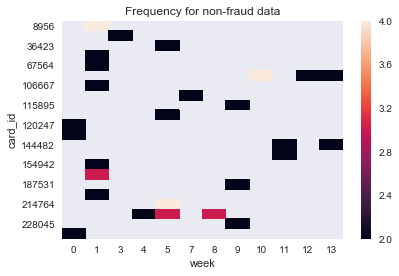

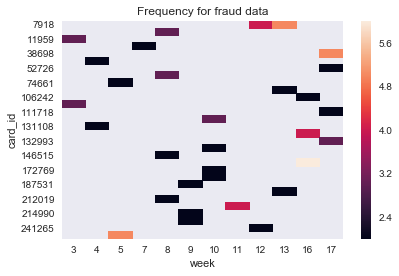

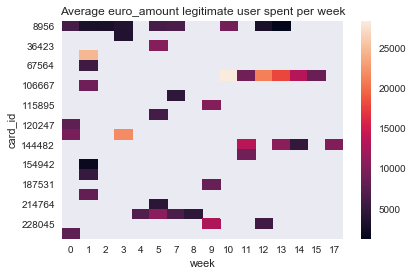

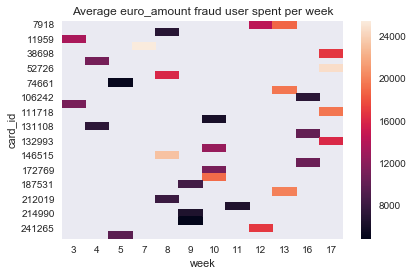

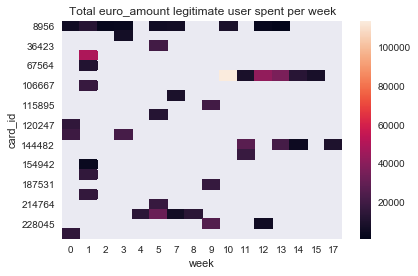

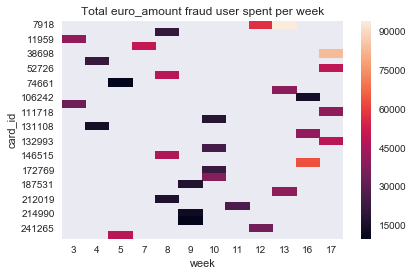

In [92]:
'''draw heatmap'''
def heat_map(data,type,title):
    sns.set()
    plt.title(title)
    data = data.pivot('week','card_id',type)
    ax = sns.heatmap(data.T,mask=data.T.isnull(), annot=False, fmt='.0%')
    plt.tight_layout()
    plt.show()

heat_map(freq,'freq','Frequency for non-fraud data')
heat_map(freq_f,'freq','Frequency for fraud data')

heat_map(amount,'euro_amount','Average euro_amount legitimate user spent per week')
heat_map(amount_f,'euro_amount','Average euro_amount fraud user spent per week')

heat_map(all_amount,'euro_amount','Total euro_amount legitimate user spent per week')
heat_map(all_amount_f,'euro_amount','Total euro_amount fraud user spent per week')